In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

%matplotlib inline

/home/michael/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def batch_data(x, y, size):
    perm = np.arange(len(x))
    np.random.shuffle(perm)
    x = x[perm]
    y = y[perm]
    return x[:size],y[:size]

In [4]:
df = pd.read_csv('train.csv')
images = df[df.columns[1:]]
given_label = df['label']

images = images.values
images = np.multiply(images, 1.0 / 255.0)
labels = pd.get_dummies(given_label).values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    labels,
                                                    test_size = .25,random_state=4444)

# Convolutional NN

### Weights, Biases, Convolution, Pooling for the Rectified Linear Units(Neuron)


In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name='weights')

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name='biases')

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name='convolution')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME', name='pool')

In [16]:
sess = tf.InteractiveSession()

In [25]:
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, [None, 784])
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))
    y_ = tf.placeholder(tf.float32, [None, 10])
    
#Inference
    with tf.name_scope('hidden1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        x_image = tf.reshape(x, [-1,28,28,1])
        hidden1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('hidden2'):
        h_pool1 = max_pool_2x2(hidden1)
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('fully_connected'):
        h_pool2 = max_pool_2x2(h_conv2)
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        fully_connected = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        dropout = tf.nn.dropout(fully_connected, keep_prob)

    with tf.name_scope('softmax'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        y_conv=tf.nn.softmax(tf.matmul(dropout, W_fc2) + b_fc2)

#Loss
    cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv), name='xentropy')
    
#Training
    tf.scalar_summary(cross_entropy.op.name, cross_entropy)
    global_step=tf.Variable(0,name='global_step',trainable=False)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,global_step=global_step)
    
#Evaluation
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Log Creation
    summary_op = tf.merge_all_summaries()
    sess = tf.Session()
    init = tf.initialize_all_variables()
    sess.run(init)
    
    summary_writer = tf.train.SummaryWriter('tensor_flow_logs',graph_def=sess.graph_def)
#TrainingLoop
    for i in range(20000):
        x_batch, y_batch = batch_data(X_train,y_train,50)
        feed_dict = {x: x_batch, y_: y_batch, keep_prob:1.0}
        sess.run([train_step,cross_entropy,accuracy],feed_dict=feed_dict)
        if i%100 == 0:
            acc = sess.run(accuracy, feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})
            summary_str = sess.run(summary_op, feed_dict=feed_dict)
            summary_writer.add_summary(summary_str, i)

            print("step %d, training accuracy %g"%(i, acc))

step 0, training accuracy 0.08
step 100, training accuracy 0.86
step 200, training accuracy 0.92
step 300, training accuracy 0.92
step 400, training accuracy 0.96
step 500, training accuracy 1
step 600, training accuracy 0.98
step 700, training accuracy 0.98
step 800, training accuracy 0.98
step 900, training accuracy 0.96
step 1000, training accuracy 0.92
step 1100, training accuracy 0.98
step 1200, training accuracy 1
step 1300, training accuracy 1
step 1400, training accuracy 1
step 1500, training accuracy 1
step 1600, training accuracy 0.98
step 1700, training accuracy 1
step 1800, training accuracy 1
step 1900, training accuracy 0.98
step 2000, training accuracy 0.98
step 2100, training accuracy 1
step 2200, training accuracy 0.96
step 2300, training accuracy 1
step 2400, training accuracy 1
step 2500, training accuracy 1
step 2600, training accuracy 1
step 2700, training accuracy 1
step 2800, training accuracy 1
step 2900, training accuracy 1
step 3000, training accuracy 0.98
ste

In [30]:
ac = sess.run(accuracy, feed_dict={x: X_test, y_: y_test, keep_prob: 1.0})

In [32]:
print("test accuracy {}".format(ac))

test accuracy 0.989238083363


# Make A Prediction

In [49]:
X_test[1].shape

(784,)

In [ ]:
y_fit = sess.run(tf.argmax(y_conv,1),feed_dict={x: , keep_prob:1})

# Visualizing Residuals

In [33]:
y_fit = sess.run(tf.argmax(y_conv,1),feed_dict={x: X_test, keep_prob:1})

In [34]:
def undummy(arr):
    num = []
    for i in arr:
        for j in range(len(i)):
            if i[j]==1.0:
                num.append(j)
    return num                 

In [35]:
ys = np.array(undummy(y_test))

In [36]:
residual_index = [i for i, (val,valb) in enumerate(zip(ys,y_fit)) if val!=valb]

In [37]:
residual = [val!=valb for i, (val,valb) in enumerate(zip(ys,y_fit))]
residual = np.array(residual)
X_images = np.array(X_test).reshape(len(X_test),28,28)
X_residual = X_images[residual]

In [38]:
def plot_averages(data,actual):
    fig = plt.figure(figsize = (10,6))
    for i in range(10):
        plt.subplot(2,5,i+1).matshow(np.mean(data[np.array(actual==i)], axis=0),cmap=plt.cm.Greys)
        plt.title('Number: {}'.format(i))
        plt.subplot(2,5,i+1).xaxis.set_ticks_position('bottom')

In [39]:
residual.shape

(10500,)

In [40]:
np.array(ys)

array([9, 0, 4, ..., 5, 8, 3])

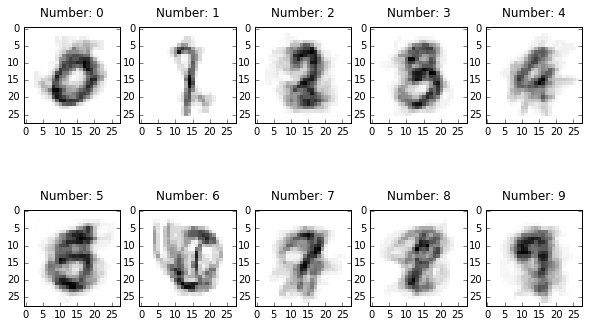

In [41]:
plot_averages(X_residual,ys[residual])

# Confusion

In [42]:
confusion = np.zeros([10,10])
for i,j in zip(ys,y_fit):
    confusion[i][j]+=1

In [43]:
percentage = confusion/np.sum(confusion, axis=1)

In [44]:
for i in range(10):
    percentage[i][i] = 0

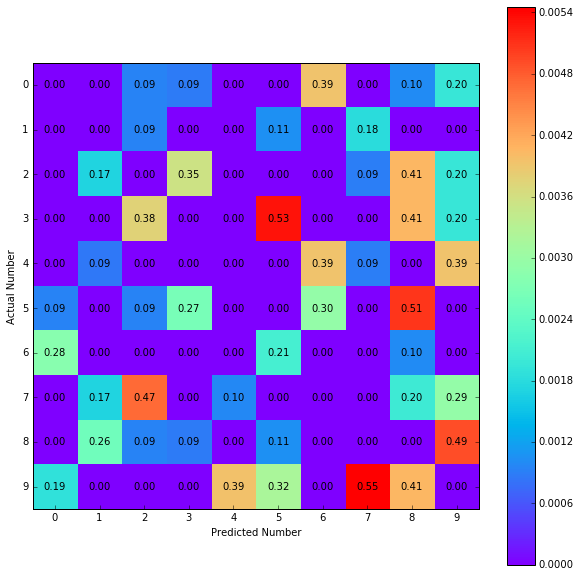

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
# plt.figure()
c = ax.matshow(percentage,cmap=plt.cm.rainbow)
fig.colorbar(c)
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel('Predicted Number')
plt.ylabel('Actual Number')

for (i, j), z in np.ndenumerate(percentage):
    ax.text(j, i, '{:0.2f}'.format(z*100), ha='center', va='center')
    ax.xaxis.set_ticks_position('bottom')

In [46]:
from sklearn.metrics import classification_report

In [47]:
print classification_report(ys,y_fit,digits=5)

             precision    recall  f1-score   support

          0    0.99435   0.99155   0.99295      1065
          1    0.99317   0.99657   0.99487      1167
          2    0.98778   0.98778   0.98778      1064
          3    0.99199   0.98671   0.98934      1129
          4    0.99504   0.99013   0.99258      1013
          5    0.98723   0.98618   0.98671       941
          6    0.98923   0.99409   0.99165      1016
          7    0.99088   0.98818   0.98953      1100
          8    0.97889   0.98883   0.98384       985
          9    0.98234   0.98137   0.98185      1020

avg / total    0.98925   0.98924   0.98924     10500

